# Load and check data

In [1]:
import time
import random
from tqdm import tqdm
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

from imageio import imread
from wordcloud import WordCloud, STOPWORDS

import gensim
import nltk

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics, model_selection, preprocessing
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.calibration import CalibratedClassifierCV

from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import SpatialDropout1D, Bidirectional
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization

from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence, text
from keras.utils import np_utils

import xgboost as xgb

Using TensorFlow backend.
/home/guido/.conda/envs/dl/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


| entity | semantic |
|-|-|
| `data_` | dataframes containing both raw data and targets |
| `i_` | indices in `data_` objects |
| `y_` | targets |
| `f_` | features |
| `p_` | predictions of models (incl. cross-validated) |
| `q_` | quality metrics (log loss) |
| `t_` | transformers |

In [2]:
# Load in the train and test datasets
data_train = pd.read_csv('../input/train.csv')
data_test = pd.read_csv('../input/test.csv')

data_full = pd.concat([data_train, data_test], ignore_index=True)

print(data_train.shape, data_test.shape, data_full.shape)

data_full.head()

(19579, 3) (8392, 2) (27971, 3)


,author,id,text
0,EAP,id26305,"This process, however, afforded me no means of..."
1,HPL,id17569,It never once occurred to me that the fumbling...
2,EAP,id11008,"In his left hand was a gold snuff box, from wh..."
3,MWS,id27763,How lovely is spring As we looked from Windsor...
4,HPL,id12958,"Finding nothing else, not even gold, the Super..."


In [22]:
# Prepare the id and label for modeling
author_mapping_dict = {'EAP': 0, 'HPL': 1, 'MWS': 2}

#y_full = data_full.author
y_full = data_full.author.map(author_mapping_dict)

i_train = ~y_full.isnull()
i_test = y_full.isnull()

#y_train = data_train.author.map(author_mapping_dict)

In [4]:
# Explore the dataset 
print("Number of rows in train dataset {}".format(data_train.shape[0]))
print("Number of rows in test dataset {}".format(data_test.shape[0]))
print("No duplicates in train data") if data_train.shape[0] == data_train.text.unique().__len__() else print("Oops")
print("No duplicates in test data") if data_test.shape[0] == data_test.text.unique().__len__() else print("Oops")
print("Unique author is data {}".format(data_train.author.unique()))
print("Number of nulls in the train is {} and text is {}".format(data_train.isnull().sum().sum(), data_test.isnull().sum().sum()))

Number of rows in train dataset 19579
Number of rows in test dataset 8392
No duplicates in train data
No duplicates in test data
Unique author is data ['EAP' 'HPL' 'MWS']
Number of nulls in the train is 0 and text is 0


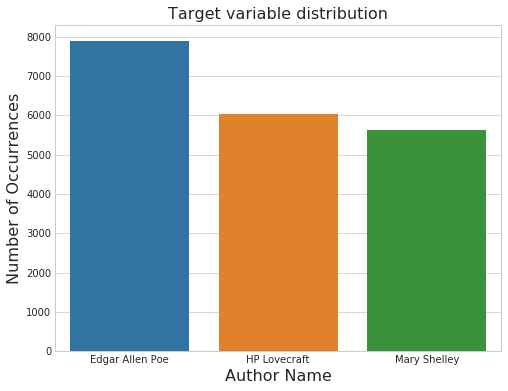

In [5]:
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}
plt.figure(figsize=(8, 6))
plt.title('Target variable distribution', fontsize=16)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Author Name', fontsize=16)
sns.barplot(x=data_train.author.map(z).unique(), y=data_train.author.value_counts().values)

# Wordclouds

## Visualise each author's work

(-0.5, 399.5, 199.5, -0.5)

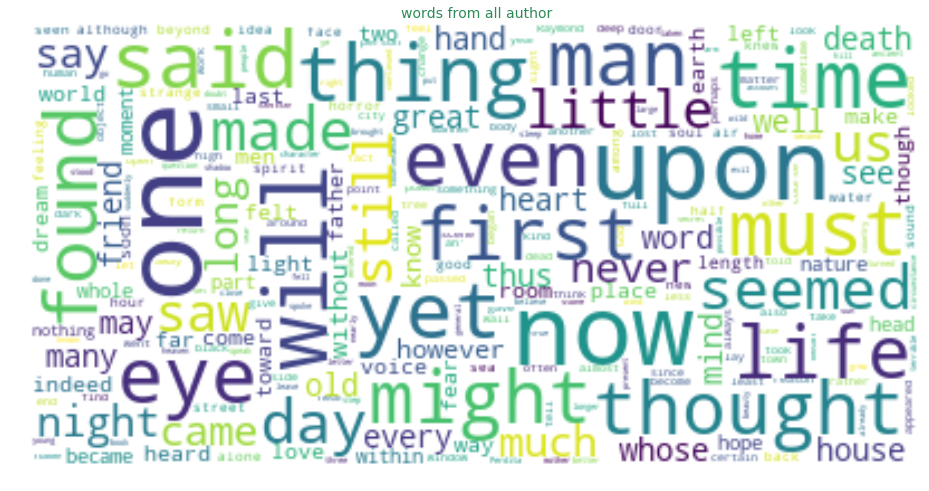

In [6]:
wc = WordCloud(
    background_color="white",
    max_words=5000,
    stopwords=STOPWORDS,
    max_font_size=50)
# generate word cloud
wc.generate(" ".join(data_train.text.values))

# show
plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("words from all author", fontsize=14, color='seagreen')
plt.axis("off")

In [7]:
img1 = imread("../images/eap.png")
img2 = imread("../images/mws.png")
img3 = imread("../images/hpl.png")

In [8]:
eap = data_train[data_train.author == "EAP"]["text"].values
mws = data_train[data_train.author == "MWS"]["text"].values
hpl = data_train[data_train.author == "HPL"]["text"].values

(-0.5, 639.5, 390.5, -0.5)

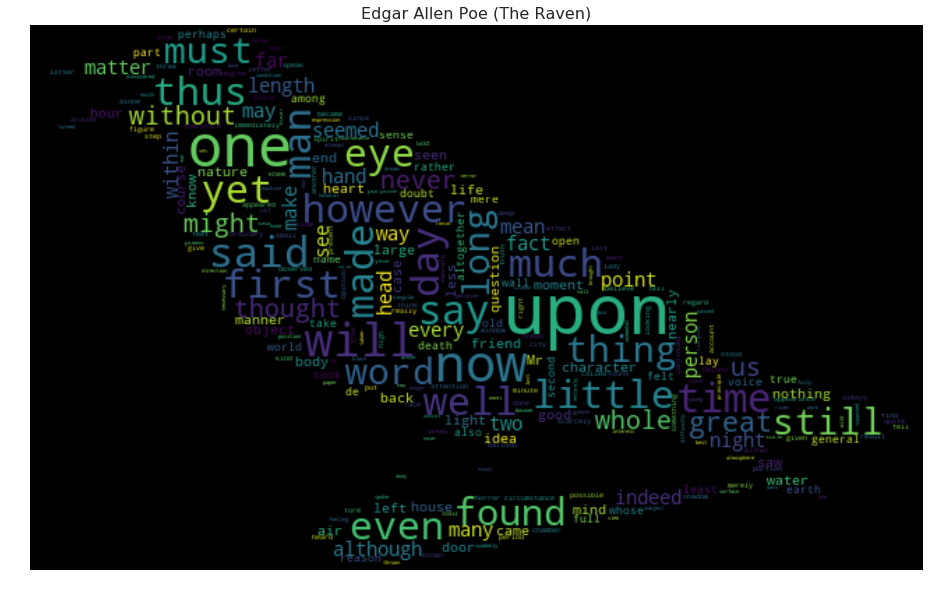

In [9]:
wc = WordCloud(
    background_color="black",
    max_words=10000,
    mask=img1,
    stopwords=STOPWORDS,
    max_font_size=50)
wc.generate(" ".join(eap))

plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Edgar Allen Poe (The Raven)", fontsize=16)
plt.axis("off")

(-0.5, 639.5, 589.5, -0.5)

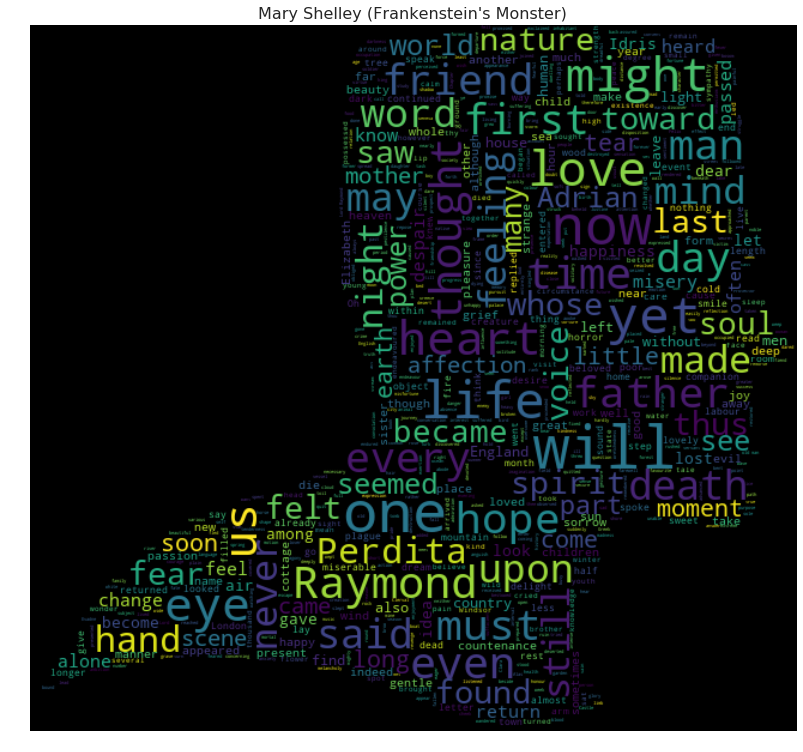

In [10]:
wc = WordCloud(
    background_color="black",
    max_words=10000,
    mask=img2,
    stopwords=STOPWORDS,
    max_font_size=50)
wc.generate(" ".join(mws))

plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Mary Shelley (Frankenstein's Monster)", fontsize=16)
plt.axis("off")

(-0.5, 511.5, 511.5, -0.5)

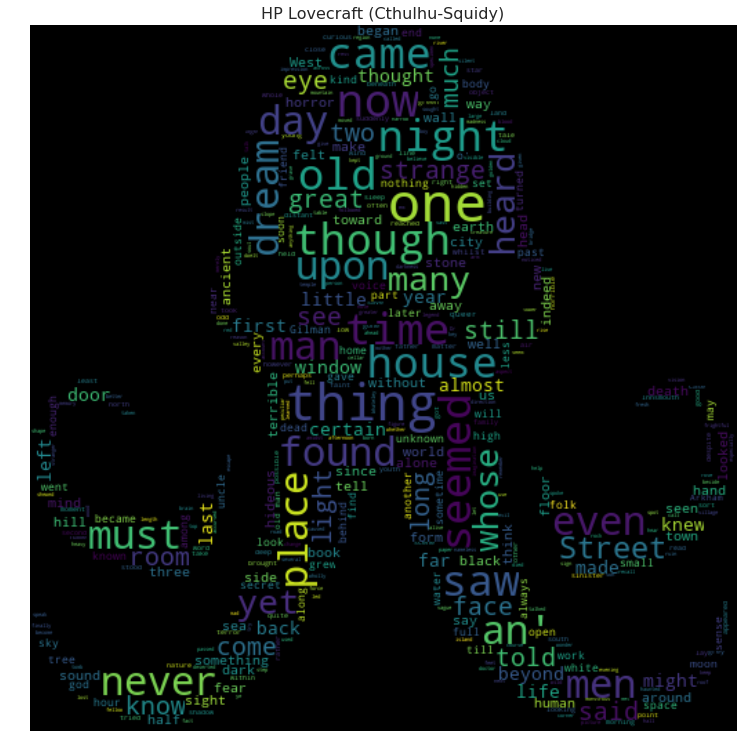

In [11]:
wc = WordCloud(
    background_color="black",
    max_words=10000,
    mask=img3,
    stopwords=STOPWORDS,
    max_font_size=40)
wc.generate(" ".join(hpl))

plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("HP Lovecraft (Cthulhu-Squidy)", fontsize=16)
plt.axis('off')

# Natural Language Processing

## Tokenization

In [12]:
# Storing the first text element as a string
first_text = data_train.text.values[0]
print(first_text)
print("="*90)
print(first_text.split(" "))

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
['This', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'I', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.']


In [13]:
first_text_list = nltk.word_tokenize(first_text)
print(first_text_list)

['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']


## Stopword Removal

In [14]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

153

In [15]:
first_text_list_cleaned = [
    word for word in first_text_list if word.lower() not in stopwords
]
print(first_text_list_cleaned)
print("=" * 90)
print("Length of original list: {} words\n"
      "Length of list after stopwords removal: {} words".format(
          len(first_text_list), len(first_text_list_cleaned)))

['process', ',', 'however', ',', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', ';', 'might', 'make', 'circuit', ',', 'return', 'point', 'whence', 'set', ',', 'without', 'aware', 'fact', ';', 'perfectly', 'uniform', 'seemed', 'wall', '.']
Length of original list: 48 words
Length of list after stopwords removal: 28 words


## Stemming and Lemmatization

In [16]:
stemmer = nltk.stem.PorterStemmer()
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run
The stemmed form of leaves is: leav


In [17]:
lemm =  nltk.stem.WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("ascertaining")))

The lemmatized form of leaves is: leaf
The lemmatized form of leaves is: ascertaining


## Vectorizing Raw Text

In [18]:
# Defining our sentence
sentence = ["I love to eat Burgers", "I love to eat Fries"]
# try CountVectorizer
vectorizer = CountVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(
    sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[1 1 0 1 1]
 [0 1 1 1 1]]


In [19]:
sentence = ["I love to eat Burgers", "I love to eat Fries"]
# try  TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(
    sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[ 0.63009934  0.44832087  0.          0.44832087  0.44832087]
 [ 0.          0.44832087  0.63009934  0.44832087  0.44832087]]


# Feature Engineering

## Basic features

In [20]:
import re
import string


def num_words(raw):
    return len(re.findall(r'\w+', raw['text']))


def num_chars(raw):
    return len(raw['text'])


def mean_len_words(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return np.mean([len(w) for w in text_list])


def num_unique_words(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return len(list(set(text_list)))


def num_stopwords(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    stopwords = nltk.corpus.stopwords.words('english')

    return len([w for w in text_list if w in stopwords])


def num_punctuations(raw):
    text = raw['text'].lower()
    text_list = nltk.word_tokenize(text)

    return len([w for w in text_list if w in string.punctuation])


def num_upper_words(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return len([w for w in text_list if w.isupper()])


def num_title_words(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return len([w for w in text_list if w.istitle()])

def num_noun_words(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    pos_list = nltk.pos_tag(text_list)
    noun_count = len(
        [w for w in pos_list if w[1] in ('NN', 'NNP', 'NNPS', 'NNS')])
    return noun_count


def num_adj_words(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    pos_list = nltk.pos_tag(text_list)
    adj_count = len([w for w in pos_list if w[1] in ('JJ', 'JJR', 'JJS')])
    return adj_count


def num_verbs_words(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    pos_list = nltk.pos_tag(text_list)
    verbs_count = len([
        w for w in pos_list
        if w[1] in ('VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ')
    ])
    return verbs_count

In [21]:
f_num_words        = data_full.apply(lambda raw: num_words(raw), axis=1).as_matrix()[:, None]
f_num_chars        = data_full.apply(lambda raw: num_chars(raw), axis=1).as_matrix()[:, None]
f_mean_len_words   = data_full.apply(lambda raw: mean_len_words(raw), axis=1).as_matrix()[:, None]

f_num_unique_words = data_full.apply(lambda raw: num_unique_words(raw), axis=1).as_matrix()[:, None]
f_num_stopwords    = data_full.apply(lambda raw: num_stopwords(raw), axis=1).as_matrix()[:, None]
f_num_punctuations = data_full.apply(lambda raw: num_punctuations(raw), axis=1).as_matrix()[:, None]
f_num_upper_words  = data_full.apply(lambda raw: num_upper_words(raw), axis=1).as_matrix()[:, None]
f_num_title_words  = data_full.apply(lambda raw: num_title_words(raw), axis=1).as_matrix()[:, None]

f_num_noun_words   = data_full.apply(lambda raw: num_noun_words(raw), axis=1).as_matrix()[:, None]
f_num_adj_words    = data_full.apply(lambda raw: num_adj_words(raw), axis=1).as_matrix()[:, None]
f_num_verbs_words  = data_full.apply(lambda raw: num_verbs_words(raw), axis=1).as_matrix()[:, None]

In [22]:
f_basic = (
    f_num_words, f_num_chars, f_mean_len_words,
    f_num_unique_words, f_num_stopwords, f_num_punctuations, f_num_title_words, f_num_upper_words,
    f_num_noun_words, f_num_adj_words, f_num_verbs_words)

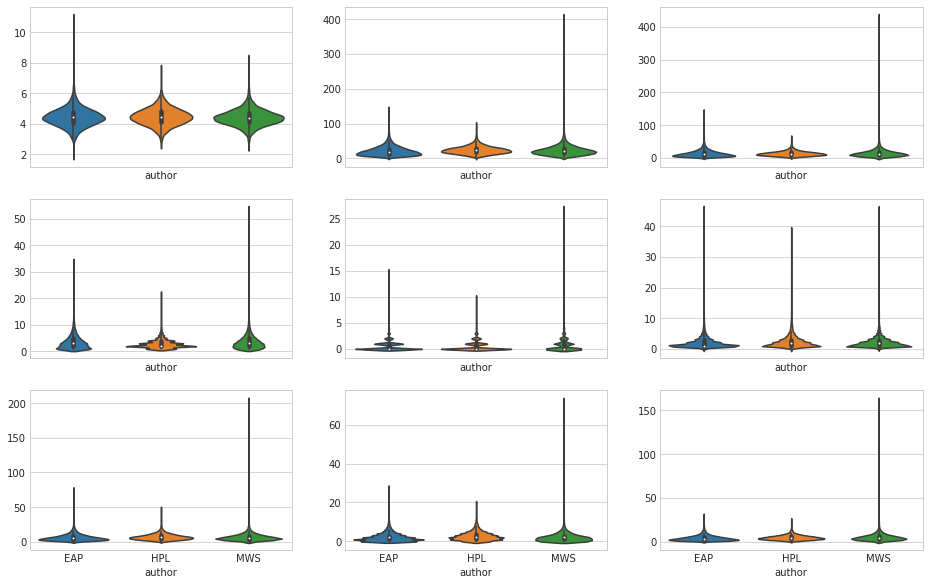

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=False, figsize=(16, 10))
sns.violinplot(x=y_full, y=f_mean_len_words.flatten(), ax=ax[0, 0])
sns.violinplot(x=y_full, y=f_num_unique_words.flatten(), ax=ax[0, 1])
sns.violinplot(x=y_full, y=f_num_stopwords.flatten(), ax=ax[0, 2])

sns.violinplot(x=y_full, y=f_num_punctuations.flatten(), ax=ax[1, 0])
sns.violinplot(x=y_full, y=f_num_upper_words.flatten(), ax=ax[1, 1])
sns.violinplot(x=y_full, y=f_num_title_words.flatten(), ax=ax[1, 2])

sns.violinplot(x=y_full, y=f_num_noun_words.flatten(), ax=ax[2, 0])
sns.violinplot(x=y_full, y=f_num_adj_words.flatten(), ax=ax[2, 1])
sns.violinplot(x=y_full, y=f_num_verbs_words.flatten(), ax=ax[2, 2])

## Word features

### Word based 6 features

In [24]:
n_components = 20

# TFIDF features
t_tfidf = TfidfVectorizer(stop_words="english", ngram_range=(1, 3)) # token_pattern=r'\w{1,}'
f_tfidf = t_tfidf.fit_transform(data_full.text)

# TFIDF with SVD features
t_svd_tfidf = TruncatedSVD(n_components=n_components, algorithm="arpack", random_state=2017)
f_svd_tfidf = t_svd_tfidf.fit_transform(f_tfidf)

# TFIDF with SVD and Scale features
t_scl_svd_tfidf = StandardScaler()
f_scl_svd_tfidf = t_scl_svd_tfidf.fit_transform(f_svd_tfidf)

# Counters features
# min_df=3, strip_accents='unicode', token_pattern=r'\w{1,}', sublinear_tf=1,
t_count = CountVectorizer(stop_words="english", ngram_range=(1, 3))
f_count = t_count.fit_transform(data_full.text)

# Counters with SVD features
t_svd_count = TruncatedSVD(n_components=n_components, algorithm="arpack", random_state=2017)
f_svd_count = t_svd_count.fit_transform(f_count.astype(float)) # float

# Counter with SVD and Scale features
t_scl_svd_count = StandardScaler()
f_scl_svd_count = t_scl_svd_count.fit_transform(f_svd_count)

### Stems based 6 features

In [25]:
stemmer = nltk.stem.PorterStemmer()


def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed


def tokenize_s(text):
    tokens = nltk.word_tokenize(text.lower())
    stems = stem_tokens(tokens, stemmer)
    return stems

In [26]:
# TFIDF features
t_tfidf_s = TfidfVectorizer(tokenizer=tokenize_s, stop_words="english", ngram_range=(1, 3))
f_tfidf_s = t_tfidf_s.fit_transform(data_full.text)

# TFIDF with SVD features
t_svd_tfidf_s = TruncatedSVD(n_components=n_components, algorithm="arpack", random_state=2017)
f_svd_tfidf_s = t_svd_tfidf_s.fit_transform(f_tfidf_s)

# TFIDF with SVD and Scale features
t_scl_svd_tfidf_s = StandardScaler()
f_scl_svd_tfidf_s = t_scl_svd_tfidf_s.fit_transform(f_svd_tfidf_s)

# Counters features
t_count_s = CountVectorizer(tokenizer=tokenize_s, stop_words="english", ngram_range=(1, 3))
f_count_s = t_count_s.fit_transform(data_full.text)

# Counters with SVD features
t_svd_count_s = TruncatedSVD(n_components=n_components, algorithm="arpack", random_state=2017)
f_svd_count_s = t_svd_count_s.fit_transform(f_count_s.astype(float))

# Counters with SVD and Scale features
t_scl_svd_count_s = StandardScaler()
f_scl_svd_count_s = t_scl_svd_count_s.fit_transform(f_svd_count_s)

### Lemmas based 6 features

In [27]:
lemmatizer = nltk.stem.WordNetLemmatizer()


def tokenize_l(text):
    lemms = []
    for i, j in nltk.pos_tag(nltk.word_tokenize(text.lower())):
        if j[0].lower() in ['a', 'n', 'v']:
            lemms.append(lemmatizer.lemmatize(i, j[0].lower()))
        else:
            lemms.append(lemmatizer.lemmatize(i))
    return lemms

In [28]:
# TFIDF features
t_tfidf_l = TfidfVectorizer(tokenizer=tokenize_l, stop_words="english", ngram_range=(1, 3))
f_tfidf_l = t_tfidf_l.fit_transform(data_full.text)

# TFIDF with SVD features
t_svd_tfidf_l = TruncatedSVD(n_components=n_components, algorithm="arpack", random_state=2017)
f_svd_tfidf_l = t_svd_tfidf_l.fit_transform(f_tfidf_l)

# TFIDF with SVD and Scale features
t_scl_svd_tfidf_l = StandardScaler()
f_scl_svd_tfidf_l = t_scl_svd_tfidf_l.fit_transform(f_svd_tfidf_l)

# Counters features
t_count_l = CountVectorizer(tokenizer=tokenize_l, stop_words="english", ngram_range=(1, 3))
f_count_l = t_count_l.fit_transform(data_full.text)

# Counters with SVD features
t_svd_count_l = TruncatedSVD(n_components=n_components, algorithm="arpack", random_state=2017)
f_svd_count_l = t_svd_count_l.fit_transform(f_count_l.astype(float))

# Counter with SVD and Scale features
t_scl_svd_count_l = StandardScaler()
f_scl_svd_count_l = t_scl_svd_count_l.fit_transform(f_svd_count_l)

## Char 6 featurs

In [29]:
# TFIDF features
t_tfidf_c = TfidfVectorizer(analyzer="char", stop_words="english", ngram_range=(1, 7))
f_tfidf_c = t_tfidf_c.fit_transform(data_full.text)

# TFIDF with SVD features
t_svd_tfidf_c = TruncatedSVD(n_components=n_components, algorithm="arpack", random_state=2017)
f_svd_tfidf_c = t_svd_tfidf_c.fit_transform(f_tfidf_c)

# TFIDF with SVD and Scale features
t_scl_svd_tfidf_c = StandardScaler()
f_scl_svd_tfidf_c = t_scl_svd_tfidf_c.fit_transform(f_svd_tfidf_c)

# Counter features
t_count_c = CountVectorizer(analyzer="char", stop_words="english", ngram_range=(1, 7))
f_count_c = t_count_c.fit_transform(data_full.text)

# Counter with SVD features
t_svd_count_c = TruncatedSVD(n_components=n_components, algorithm="arpack", random_state=2017)
f_svd_count_c = t_svd_count_c.fit_transform(f_count_c.astype(float))

# Counter with SVD and Scale features
t_scl_svd_count_c = StandardScaler()
f_scl_svd_count_c = t_scl_svd_count_c.fit_transform(f_svd_count_c)

## Markov event based features

In [4]:
class Dictogram(dict):
    def __init__(self, iterable=None):
        """Initialize this histogram as a new dict; update with given items"""
        super(Dictogram, self).__init__()
        self.types = 0  # the number of distinct item types in this histogram
        self.tokens = 0  # the total count of all item tokens in this histogram
        if iterable:
            self.update(iterable)

    def update(self, iterable):
        """Update this histogram with the items in the given iterable"""
        for item in iterable:
            if item in self:
                self[item] += 1
                self.tokens += 1
            else:
                self[item] = 1
                self.types += 1
                self.tokens += 1

In [5]:
# markov chain based features, order words memory
def make_higher_order_markov_model(data, order):
    markov_model = dict()

    for char_list in data:
        for i in range(len(char_list) - order):
            # Create the window
            window = tuple(char_list[i:i + order])
            # Add to the dictionary
            if window in markov_model:
                # We have to just append to the existing Dictogram
                markov_model[window].update([char_list[i + order]])
            else:
                markov_model[window] = Dictogram([char_list[i + order]])
    return markov_model


def make_tuples(char_list, order):
    """function to make tuples of order size given a char_list and order"""
    list_of_tuple = []
    chars = []
    for i in range(len(char_list) - order):
        window = tuple(char_list[i:i + order])
        list_of_tuple.append(window)
        chars.append(char_list[i + order])
    return (list_of_tuple, chars)


def sent_to_prob(raw, order, MM):
    """function to get the markov model to give prob of a author given a char_list """
    char_list = raw['splited_char_list']
    list_of_tuples, chars = make_tuples(char_list, order)

    p = 0

    # convert to log so we can sum probabilities instead of multiply
    for i in range(len(chars)):
        try:
            p_char = MM[list_of_tuples[i]][chars[i]]
            p_chars = sum([x for x in MM[list_of_tuples[i]].values()])
        except:
            p_char = 1
            p_chars = 1
        p += np.log(p_char / p_chars)
    return p


def text_to_char_list(raw):
    text = raw['text'].lower()
    char_list = [c for c in text]

    return char_list

In [6]:
start_order, end_order = 2, 3 # [start_order, end_order)

data_full['splited_char_list'] = data_full.apply(lambda raw: text_to_char_list(raw), axis=1)

raw_eap = data_full[data_full.author == 'EAP']['splited_char_list'].values
raw_hpl = data_full[data_full.author == 'HPL']['splited_char_list'].values
raw_mws = data_full[data_full.author == 'MWS']['splited_char_list'].values

f_markov = []

for order in range(start_order, end_order):
    # build markov model
    eap_MM = make_higher_order_markov_model(raw_eap, order)
    hpl_MM = make_higher_order_markov_model(raw_hpl, order)
    mws_MM = make_higher_order_markov_model(raw_mws, order)

    # create markov features
    f_markov.append(data_full.apply(lambda raw: sent_to_prob(raw, order, eap_MM), axis=1).as_matrix()[:, None])
    f_markov.append(data_full.apply(lambda raw: sent_to_prob(raw, order, hpl_MM), axis=1).as_matrix()[:, None])
    f_markov.append(data_full.apply(lambda raw: sent_to_prob(raw, order, mws_MM), axis=1).as_matrix()[:, None])
    
del data_full['splited_char_list']

In [18]:
#full_data = [data_train, data_test]
#start_order, end_order = 2, 3 # [start_order, end_order)
#
#for dataset in full_data:
#    dataset['splited_char_list'] = dataset.apply(lambda raw: text_to_char_list(raw), axis=1)
#
#raw_eap = data_train[data_train.author == 'EAP']['splited_char_list'].values
#raw_hpl = data_train[data_train.author == 'HPL']['splited_char_list'].values
#raw_mws = data_train[data_train.author == 'MWS']['splited_char_list'].values
#
#
#for order in range(start_order, end_order):
#    # build markov model
#    eap_MM = make_higher_order_markov_model(raw_eap, order)
#    hpl_MM = make_higher_order_markov_model(raw_hpl, order)
#    mws_MM = make_higher_order_markov_model(raw_mws, order)
#
#    # create markov features
#    for dataset in full_data:
#        dataset['EAP_markov_' + str(order)] = dataset.apply(lambda raw: sent_to_prob(raw, order, eap_MM), axis=1)
#        dataset['HPL_markov_' + str(order)] = dataset.apply(lambda raw: sent_to_prob(raw, order, hpl_MM), axis=1)
#        dataset['MWS_markov_' + str(order)] = dataset.apply(lambda raw: sent_to_prob(raw, order, mws_MM), axis=1)
#    
#for dataset in full_data:
#    del dataset['splited_char_list']

In [17]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
#b = normalize(a, axis=1)
#c = StandardScaler().fit_transform(a)

f_markov_h = np.hstack(f_markov)
f_markov_t = np.zeros(f_markov_h.shape)
for idx, row in enumerate(f_markov):
    f_markov_t[idx] = (row - row.min()) / (row.max() - row.min())

f_markov = f_markov_t
print(f_markov.shape)

[ 0.  0.  0. ...,  0.  0.  0.]


In [11]:
#for order in range(start_order, end_order):
#    select_elements = ['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)]
#    tmp_train = data_train[select_elements]
#    tmp_test = data_test[select_elements]
#    
#    data_train = data_train.drop(select_elements, axis=1)
#    data_test = data_test.drop(select_elements, axis=1)
#
#    # Min-max normalization (row)
#    tmp_train = tmp_train.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
#    tmp_test = tmp_test.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
#    
#    data_train = pd.concat([data_train, tmp_train], axis=1)
#    data_test = pd.concat([data_test, tmp_test], axis=1)

In [19]:
#markov_train = pd.DataFrame()
#markov_test = pd.DataFrame()
#for order in range(start_order, end_order):
#    markov_train = pd.concat(
#        [
#            markov_train, data_train[['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)]]
#        ],
#        axis=1)
#    markov_test = pd.concat(
#        [
#            markov_test, data_test[['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)]]
#        ],
#        axis=1)
#markov_train.head()
##markov_test.head()

In [ ]:
#print(eap_MM[('n', 'o', 'm', 'e')])
#print(sum([x for x in eap_MM[('n', 'o', 'm', 'e')].values()]))
#print(eap_MM[('n', 'o', 'm', 'e')]['r'])
#print(eap_MM[('n', 'o', 'm', 'e')]['r'] / sum([x for x in eap_MM[('n', 'o', 'm', 'e')].values()]))

## Sentence vector features

### word2vec

In [ ]:
# Load Google's pre-trained Word2Vec model.
#word2vec = gensim.models.KeyedVectors.load_word2vec_format('../model/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')


def sent2vec(sentence):
    text_list = tokenizer.tokenize(sentence.lower())
    text_list = [w for w in text_list if w not in stopwords]
    text_list = [w for w in text_list if w.isalpha()]
    
    M = []
    for w in text_list:
        try:
            M.append(word2vec[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [ ]:
#start = time.time()
#
#train_text = train.text.values
#test_text = test.text.values
#sentvec_train = [sent2vec(x) for x in train_text]
#sentvec_test = [sent2vec(x) for x in test_text]
#
#sve_train = np.array(sentvec_train)
#sve_test = np.array(sentvec_test)
#
#print(sve_train.shape, sve_test.shape)
#
#end = time.time()
#print("Time is {}.".format(end - start))

In [ ]:
#sve_train[:10]

In [24]:
#np.save('../model/sve_train', sve_train)
#np.save('../model/sve_test', sve_test)
sve_train = np.load('../model/sve_train.npy')
sve_test = np.load('../model/sve_test.npy')

f_sentv = np.concatenate((sve_train, sve_test), axis=0)
print(f_sentv.shape)

(27971, 300)


### glove

In [ ]:
glove_file = '../glove/glove.840B.300d.txt'


# load the GloVe vectors in a dictionary:
def loadGloveEmbeddings(glove_file):
    embeddings_index = {}
    with open(glove_file) as f:
        for line in tqdm(f):
            values = line.split(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index


#loadGloveEmbeddings(glove_file)

## Sentiment Analysis based features

# Ensembling & Stacking models

## Helper functions

In [89]:
import scipy.sparse

cv = StratifiedKFold(n_splits=5)


def apply_model(model, features, evaluate=True, predict=False):
    if any(map(lambda z: type(z) in [scipy.sparse.csr_matrix, scipy.sparse.csc_matrix, scipy.sparse.coo_matrix], features)):
        hstack = scipy.sparse.hstack
    else:
        hstack = np.hstack

    f_all = hstack(features)
    f_train = f_all[np.nonzero(i_train)]
    f_test = f_all[np.nonzero(i_test)]
    
    p_cv = model_selection.cross_val_predict(model, f_train, y_train, cv=cv, method="predict_proba")
    q_cv = metrics.log_loss(y_train, p_cv)

    model.fit(f_train, y_train)

    p_train = model.predict_proba(f_train)
    q_train = metrics.log_loss(y_train, p_train)

    if evaluate:
        print(f"train log loss = {q_train:.5f}")
        print(f"   cv log loss = {q_cv:.5f}")

    if predict:
        p_test = model.predict_proba(f_test)
        p_full = np.concatenate((p_cv, p_test), axis=0)
        return pd.DataFrame(p_full)

In [59]:
# Confusion Matrix
import itertools
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Output of the First level Predictions

In [116]:
from sklearn.calibration import CalibratedClassifierCV

In [117]:
apply_model(CalibratedClassifierCV(LogisticRegression(max_iter=10), method="sigmoid"), f_basic)
apply_model(CalibratedClassifierCV(LogisticRegression(max_iter=10), method="isotonic"), f_basic)

train log loss = 0.98602
   cv log loss = 0.98714
train log loss = 0.98065
   cv log loss = 0.98801


### models using Basic features

In [112]:
# lr model
p_lr_basic = apply_model(LogisticRegression(), f_basic, predict=True)

# nb model
p_nb_basic = apply_model(MultinomialNB(), f_basic, predict=True)

# RandomForestClassifier model

# ExtraTreesClassifier model

train log loss = 0.98495
   cv log loss = 0.98634
train log loss = 1.02181
   cv log loss = 1.02306


### model using word based 6 features

In [111]:
# lr model
p_lr_tfidf = apply_model(LogisticRegression(), (f_tfidf, ), predict=True)
p_lr_svd_tfidf = apply_model(LogisticRegression(), (f_svd_tfidf, ), predict=True)
p_lr_scl_svd_tfidf = apply_model(LogisticRegression(), (f_scl_svd_tfidf, ), predict=True)

p_lr_count = apply_model(LogisticRegression(), (f_count, ), predict=True)
p_lr_svd_count = apply_model(LogisticRegression(), (f_svd_count, ), predict=True)
p_lr_scl_svd_count = apply_model(LogisticRegression(), (f_scl_svd_count, ), predict=True)

# nb model
p_nb_tfidf = apply_model(MultinomialNB(), (f_tfidf, ), predict=True)
p_nb_svd_tfidf = apply_model(MultinomialNB(), (f_svd_tfidf, ), predict=True)
p_nb_scl_svd_tfidf = apply_model(MultinomialNB(), (f_scl_svd_tfidf, ), predict=True)

p_nb_count = apply_model(MultinomialNB(), (f_count, ), predict=True)
p_nb_svd_count = apply_model(MultinomialNB(), (f_svd_count, ), predict=True)
p_nb_scl_svd_count = apply_model(MultinomialNB(), (f_scl_svd_count, ), predict=True)

train log loss = 0.60284
   cv log loss = 0.83517
train log loss = 0.97553
   cv log loss = 0.98460
train log loss = 0.91701
   cv log loss = 0.92043
train log loss = 0.11811
   cv log loss = 0.53677
train log loss = 0.98263
   cv log loss = 0.98513
train log loss = 0.98165
   cv log loss = 0.98404


### model using word stems based 6 features

In [111]:
# lr model
p_lr_tfidf_s = apply_model(LogisticRegression(), (f_tfidf_s, ), predict=True)
p_lr_svd_tfidf_s = apply_model(LogisticRegression(), (f_svd_tfidf_s, ), predict=True)
p_lr_scl_svd_tfidf_s = apply_model(LogisticRegression(), (f_scl_svd_tfidf_s, ), predict=True)

p_lr_count_s = apply_model(LogisticRegression(), (f_count_s, ), predict=True)
p_lr_svd_count_s = apply_model(LogisticRegression(), (f_svd_count_s, ), predict=True)
p_lr_scl_svd_count_s = apply_model(LogisticRegression(), (f_scl_svd_count_s, ), predict=True)

# nb model
p_nb_tfidf_s = apply_model(MultinomialNB(), (f_tfidf_s, ), predict=True)
p_nb_svd_tfidf_s = apply_model(MultinomialNB(), (f_svd_tfidf_s, ), predict=True)
p_nb_scl_svd_tfidf_s = apply_model(MultinomialNB(), (f_scl_svd_tfidf_s, ), predict=True)

p_nb_count_s = apply_model(MultinomialNB(), (f_count_s, ), predict=True)
p_nb_svd_count_s = apply_model(MultinomialNB(), (f_svd_count_s, ), predict=True)
p_nb_scl_svd_count_s = apply_model(MultinomialNB(), (f_scl_svd_count_s, ), predict=True)

train log loss = 0.60284
   cv log loss = 0.83517
train log loss = 0.97553
   cv log loss = 0.98460
train log loss = 0.91701
   cv log loss = 0.92043
train log loss = 0.11811
   cv log loss = 0.53677
train log loss = 0.98263
   cv log loss = 0.98513
train log loss = 0.98165
   cv log loss = 0.98404


### model using word lemmas based 6 features

In [111]:
# lr model
p_lr_tfidf_l = apply_model(LogisticRegression(), (f_tfidf_l, ), predict=True)
p_lr_svd_tfidf_l = apply_model(LogisticRegression(), (f_svd_tfidf_l, ), predict=True)
p_lr_scl_svd_tfidf_l = apply_model(LogisticRegression(), (f_scl_svd_tfidf_l, ), predict=True)

p_lr_count_l = apply_model(LogisticRegression(), (f_count_l, ), predict=True)
p_lr_svd_count_l = apply_model(LogisticRegression(), (f_svd_count_l, ), predict=True)
p_lr_scl_svd_count_l = apply_model(LogisticRegression(), (f_scl_svd_count_l, ), predict=True)

# nb model
p_nb_tfidf_l = apply_model(MultinomialNB(), (f_tfidf_l, ), predict=True)
p_nb_svd_tfidf_l = apply_model(MultinomialNB(), (f_svd_tfidf_l, ), predict=True)
p_nb_scl_svd_tfidf_l = apply_model(MultinomialNB(), (f_scl_svd_tfidf_l, ), predict=True)

p_nb_count_l = apply_model(MultinomialNB(), (f_count_l, ), predict=True)
p_nb_svd_count_l = apply_model(MultinomialNB(), (f_svd_count_l, ), predict=True)
p_nb_scl_svd_count_l = apply_model(MultinomialNB(), (f_scl_svd_count_l, ), predict=True)

train log loss = 0.60284
   cv log loss = 0.83517
train log loss = 0.97553
   cv log loss = 0.98460
train log loss = 0.91701
   cv log loss = 0.92043
train log loss = 0.11811
   cv log loss = 0.53677
train log loss = 0.98263
   cv log loss = 0.98513
train log loss = 0.98165
   cv log loss = 0.98404


### model using char based 6 features

In [111]:
# lr model
p_lr_tfidf_c = apply_model(LogisticRegression(), (f_tfidf_c, ), predict=True)
p_lr_svd_tfidf_c = apply_model(LogisticRegression(), (f_svd_tfidf_c, ), predict=True)
p_lr_scl_svd_tfidf_c = apply_model(LogisticRegression(), (f_scl_svd_tfidf_c, ), predict=True)

p_lr_count_c = apply_model(LogisticRegression(), (f_count_c, ), predict=True)
p_lr_svd_count_c = apply_model(LogisticRegression(), (f_svd_count_c, ), predict=True)
p_lr_scl_svd_count_c = apply_model(LogisticRegression(), (f_scl_svd_count_c, ), predict=True)

# nb model
p_nb_tfidf_c = apply_model(MultinomialNB(), (f_tfidf_c, ), predict=True)
p_nb_svd_tfidf_c = apply_model(MultinomialNB(), (f_svd_tfidf_c, ), predict=True)
p_nb_scl_svd_tfidf_c = apply_model(MultinomialNB(), (f_scl_svd_tfidf_c, ), predict=True)

p_nb_count_c = apply_model(MultinomialNB(), (f_count_c, ), predict=True)
p_nb_svd_count_c = apply_model(MultinomialNB(), (f_svd_count_c, ), predict=True)
p_nb_scl_svd_count_c = apply_model(MultinomialNB(), (f_scl_svd_count_c, ), predict=True)

train log loss = 0.60284
   cv log loss = 0.83517
train log loss = 0.97553
   cv log loss = 0.98460
train log loss = 0.91701
   cv log loss = 0.92043
train log loss = 0.11811
   cv log loss = 0.53677
train log loss = 0.98263
   cv log loss = 0.98513
train log loss = 0.98165
   cv log loss = 0.98404


### models using Markov event based features

In [25]:
# lr model
p_lr_markov = apply_model(LogisticRegression(), (f_markov, ), predict=True)

# nb model
p_nb_markov = apply_model(MultinomialNB(), (f_markov, ), predict=True)

NameError: name 'apply_model' is not defined

In [25]:
# lr model
p_lr_markov_h = apply_model(LogisticRegression(), (f_markov_h, ), predict=True)

# nb model
p_nb_markov_h = apply_model(MultinomialNB(), (f_markov_h, ), predict=True)

NameError: name 'apply_model' is not defined

### models using Sentence vector features

In [25]:
# lr model
p_lr_sentv = apply_model(LogisticRegression(), (f_sentv, ), predict=True)

# nb model
p_nb_sentv = apply_model(MultinomialNB(), (f_sentv, ), predict=True)

NameError: name 'apply_model' is not defined

In [74]:
lr_params = {'C': 3.0, 'penalty': 'l2'}
lr = SklearnHelper(clf=LogisticRegression, seed=SEED, params=lr_params)
lr_oof_sve_train, lr_oof_sve_test = get_oof(lr, sve_train, y_train, sve_test)       # 0.762 -> 0.758, 15.06s

#mnb_oof_sve_train, mnb_oof_sve_test = get_oof(mnb, sve_train, y_train, sve_test)   # non-negative

rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
rf_oof_sve_train, rf_oof_sve_test = get_oof(rf, sve_train, y_train, sve_test)       # 0.967 -> -, 14.35s

et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
et_oof_sve_train, et_oof_sve_test = get_oof(et, sve_train, y_train, sve_test)

Mean cv score: 0.7579693509183102
Mean cv score: 1.0463075477164197
Mean cv score: 1.0469980131125656


In [82]:
# add the predictions as new features
columns = ['lr_oof_sve_eap', 'lr_oof_sve_hpl', 'lr_oof_sve_mws']
train = pd.concat([train, pd.DataFrame(lr_oof_sve_train, index=train.index, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(lr_oof_sve_test, index=test.index, columns=columns)], axis=1)

columns = ['rf_oof_sve_eap', 'rf_oof_sve_hpl', 'rf_oof_sve_mws']
train = pd.concat([train, pd.DataFrame(rf_oof_sve_train, index=train.index, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(rf_oof_sve_test, index=test.index, columns=columns)], axis=1)

columns = ['et_oof_sve_eap', 'et_oof_sve_hpl', 'et_oof_sve_mws']
train = pd.concat([train, pd.DataFrame(et_oof_sve_train, index=train.index, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(et_oof_sve_test, index=test.index, columns=columns)], axis=1)

### Confusion matrix

Confusion matrix, without normalization
[[5714 1019 1167]
 [1326 3616  693]
 [1319  709 4016]]


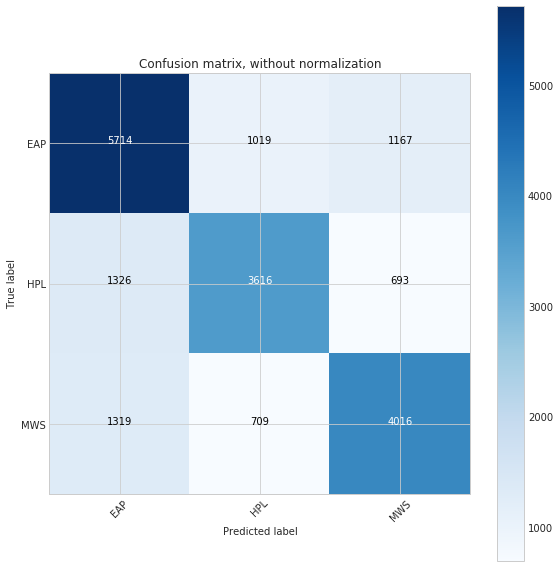

In [76]:
cnf_matrix = confusion_matrix(y_train, np.argmax(lr_oof_sve_train, axis=1))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

## Second-Level Predictions from the First-level Output

### Checkpoint

In [20]:
#train.to_pickle('../model/train-20171205-04-add-markov.pkl')
#test.to_pickle('../model/test-20171205-04-add-markov.pkl')
train = pd.read_pickle('../model/train-20171205-04-add-markov.pkl')
test = pd.read_pickle('../model/test-20171205-04-add-markov.pkl')

train.head()

,id,text,author,word_count,char_count,word_len_mean,unique_word_count,stopwords_count,punctuations_count,word_upper_count,...,lr_oof_markov_mws,mnb_oof_markov_eap,mnb_oof_markov_hpl,mnb_oof_markov_mws,rf_oof_markov_eap,rf_oof_markov_hpl,rf_oof_markov_mws,et_oof_markov_eap,et_oof_markov_hpl,et_oof_markov_mws
0,id26305,"This process, however, afforded me no means of...",EAP,41,231,4.487805,35,20,7,2,...,0.071754,0.770783,0.129443,0.099774,0.735629,0.140664,0.123707,0.722126,0.158460,0.119414
1,id17569,It never once occurred to me that the fumbling...,HPL,14,71,4.071429,14,8,1,0,...,0.023169,0.265983,0.623600,0.110417,0.253184,0.602714,0.144102,0.308940,0.562522,0.128538
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,200,4.444444,32,17,5,0,...,0.004432,0.435538,0.500189,0.064274,0.323982,0.541249,0.134769,0.426293,0.459659,0.114048
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,206,4.970588,31,13,4,0,...,0.639241,0.188070,0.275640,0.536290,0.250293,0.175839,0.573868,0.214350,0.217635,0.568015
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,174,5.333333,25,11,4,0,...,0.028562,0.768244,0.112554,0.119202,0.734594,0.141773,0.123633,0.739373,0.149923,0.110704


In [60]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# load json and create model
json2_file = open('model2.json', 'r')
loaded_model2_json = json2_file.read()
json2_file.close()
loaded_model2 = model_from_json(loaded_model2_json)
loaded_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# load weights into new model
loaded_model2.load_weights("model2.h5")
print("Loaded model from disk")

Loaded model from disk
Loaded model from disk


In [66]:
#score = loaded_model.evaluate(xvalid_pad, yvalid, verbose=0)
#print('Test loss: {}'.format(score[0]))
#print('Test accuracy: {}'.format(score[1]))

lstm_train = loaded_model.predict(xtrain_pad, batch_size=256)
lstm_test = loaded_model.predict(xtest_pad, batch_size=256)

lstm_train[:10]

array([[ 0.51632798,  0.25286543,  0.23080659],
       [ 0.16239415,  0.30062905,  0.53697675],
       [ 0.53022891,  0.31512594,  0.15464525],
       [ 0.77481425,  0.1359192 ,  0.08926644],
       [ 0.13735546,  0.80081326,  0.0618312 ],
       [ 0.6158886 ,  0.25798211,  0.12612936],
       [ 0.2304244 ,  0.62313491,  0.14644065],
       [ 0.29038092,  0.4478209 ,  0.26179823],
       [ 0.414083  ,  0.5184567 ,  0.06746029],
       [ 0.52510774,  0.28421497,  0.1906773 ]], dtype=float32)

In [67]:
#score = loaded_model2.evaluate(xvalid_pad, yvalid, verbose=0)
#print('Test loss: {}'.format(score[0]))
#print('Test accuracy: {}'.format(score[1]))

gru_train = loaded_model2.predict(xtrain_pad, batch_size=256)
gru_test = loaded_model2.predict(xtest_pad, batch_size=256)

gru_train[:10]

array([[ 0.4468604 ,  0.27969381,  0.27344584],
       [ 0.13588952,  0.26042879,  0.60368162],
       [ 0.37065294,  0.43356717,  0.19577986],
       [ 0.64107227,  0.26480281,  0.09412484],
       [ 0.18414539,  0.69578528,  0.1200693 ],
       [ 0.56225026,  0.29033524,  0.14741449],
       [ 0.20580117,  0.65319759,  0.14100125],
       [ 0.25149843,  0.39366356,  0.35483807],
       [ 0.37336779,  0.53096133,  0.0956709 ],
       [ 0.42682225,  0.3303639 ,  0.24281389]], dtype=float32)

In [68]:
np.save('../model/lstm_train', lstm_train)
np.save('../model/gru_train', gru_train)

In [69]:
columns = ['lstm_eap', 'lstm_hpl', 'lstm_mws']
train = pd.concat([train, pd.DataFrame(lstm_train, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(lstm_test, columns=columns)], axis=1)

columns = ['gru_eap', 'gru_hpl', 'gru_mws']
train = pd.concat([train, pd.DataFrame(gru_train, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(gru_test, columns=columns)], axis=1)

### First-level output as new features

#### kfold method

In [21]:
# Prepare the data for modeling
drop_elements = ['id', 'text']
x_train = train.drop(drop_elements + ['author'], axis=1)
x_test = test.drop(drop_elements, axis=1)

print(x_train.shape, x_test.shape)
x_train.head()

(19579, 364) (8392, 364)


,word_count,char_count,word_len_mean,unique_word_count,stopwords_count,punctuations_count,word_upper_count,word_title_count,unique_word_fraction,stopwords_fraction,...,lr_oof_markov_mws,mnb_oof_markov_eap,mnb_oof_markov_hpl,mnb_oof_markov_mws,rf_oof_markov_eap,rf_oof_markov_hpl,rf_oof_markov_mws,et_oof_markov_eap,et_oof_markov_hpl,et_oof_markov_mws
0,41,231,4.487805,35,20,7,2,3,0.853659,0.487805,...,0.071754,0.770783,0.129443,0.099774,0.735629,0.140664,0.123707,0.722126,0.158460,0.119414
1,14,71,4.071429,14,8,1,0,1,1.000000,0.571429,...,0.023169,0.265983,0.623600,0.110417,0.253184,0.602714,0.144102,0.308940,0.562522,0.128538
2,36,200,4.444444,32,17,5,0,1,0.888889,0.472222,...,0.004432,0.435538,0.500189,0.064274,0.323982,0.541249,0.134769,0.426293,0.459659,0.114048
3,34,206,4.970588,31,13,4,0,4,0.911765,0.382353,...,0.639241,0.188070,0.275640,0.536290,0.250293,0.175839,0.573868,0.214350,0.217635,0.568015
4,27,174,5.333333,25,11,4,0,2,0.925926,0.407407,...,0.028562,0.768244,0.112554,0.119202,0.734594,0.141773,0.123633,0.739373,0.149923,0.110704


In [22]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(x_train):
    x_dev, x_val = x_train.loc[idx_dev], x_train.loc[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runXGB(x_dev, y_dev, x_val, y_val, x_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
    break # important, only run once

#pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score: {}".format(np.mean(cv_scores)))

[0]	train-mlogloss:0.996124	val-mlogloss:0.995866
Multiple eval metrics have been passed: 'val-mlogloss' will be used for early stopping.

Will train until val-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.281235	val-mlogloss:0.289034
[80]	train-mlogloss:0.234831	val-mlogloss:0.261297
[120]	train-mlogloss:0.207297	val-mlogloss:0.255918
[160]	train-mlogloss:0.185845	val-mlogloss:0.254443
[200]	train-mlogloss:0.167378	val-mlogloss:0.254094
[240]	train-mlogloss:0.151557	val-mlogloss:0.254465
Stopping. Best iteration:
[191]	train-mlogloss:0.171491	val-mlogloss:0.253714

Mean cv score: 0.2537138345236064


In [25]:
out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', id_test)
out_df.to_csv("../result/submission-20171206-05-add-markov.csv", index=False)

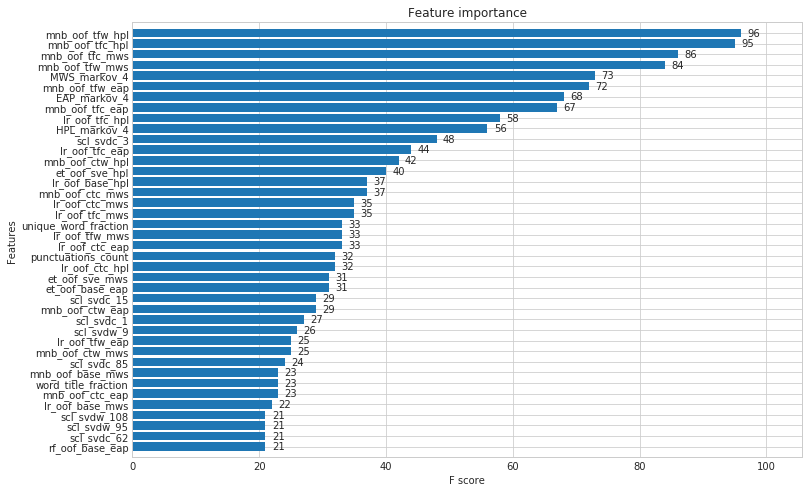

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(
    dict(
        sorted(model.get_fscore().items(), reverse=True, key=lambda x: x[1])
        [:40]),
    ax=ax,
    height=0.8)
plt.show()

Confusion matrix, without normalization
[[1387   49  100]
 [  74 1058   36]
 [ 100   47 1065]]


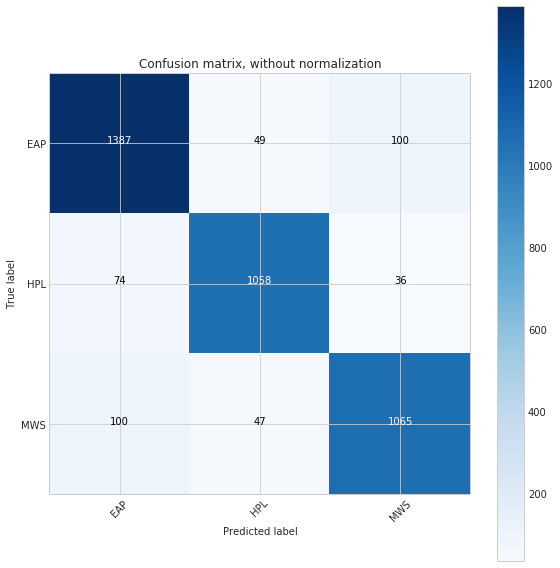

In [71]:
cnf_matrix = confusion_matrix(y_val, np.argmax(pred_y_val, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

#### train_test_split method

In [23]:
xtrain, xval, ytrain, yval = model_selection.train_test_split(
    x_train, y_train, test_size=0.2, random_state=2017)
dtrain = xgb.DMatrix(xtrain, label=ytrain)
dval = xgb.DMatrix(xval, label=yval)
dtest = xgb.DMatrix(x_test)
watchlist = [(dtrain, 'train'), (dval, 'valid')]

model_2 = xgb.train(
    xgb_param,
    dtrain,
    2000,
    watchlist,
    early_stopping_rounds=50,
    maximize=False,
    verbose_eval=40)

[0]	train-mlogloss:0.996133	valid-mlogloss:0.996175
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.281451	valid-mlogloss:0.289008
[80]	train-mlogloss:0.234406	valid-mlogloss:0.261672
[120]	train-mlogloss:0.206549	valid-mlogloss:0.255631
[160]	train-mlogloss:0.18558	valid-mlogloss:0.254232
[200]	train-mlogloss:0.166806	valid-mlogloss:0.255066
Stopping. Best iteration:
[184]	train-mlogloss:0.174003	valid-mlogloss:0.254109



In [24]:
pred_y_test = model_2.predict(dtest, ntree_limit=model_2.best_ntree_limit)

out_df = pd.DataFrame(pred_y_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', id_test)
out_df.to_csv("../result/submission-20171206-04-add-markov.csv", index=False)

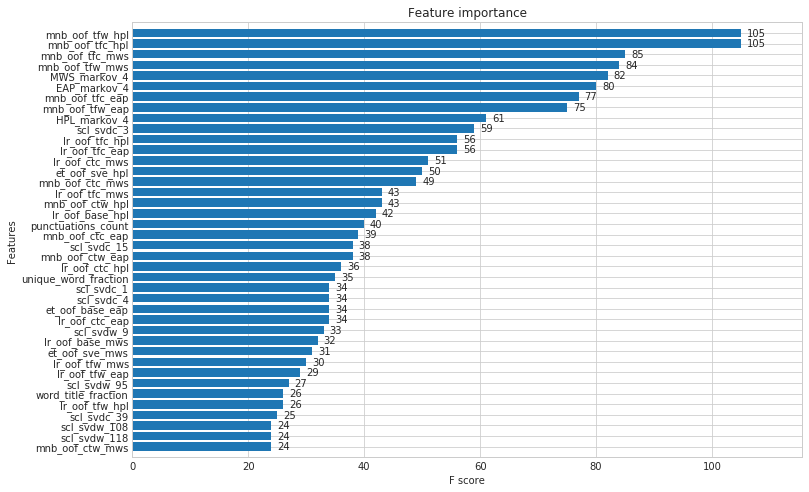

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(
    dict(
        sorted(model_2.get_fscore().items(), reverse=True, key=lambda x: x[1])
        [:40]),
    ax=ax,
    height=0.8)
plt.show()

#### fine tune xgboost

In [87]:
drop_elements = ['id', 'text', 'mnb_oof_tfc_eap', 'mnb_oof_tfc_hpl', 'mnb_oof_tfc_mws']
x_train = train.drop(drop_elements + ['author'], axis=1)
x_test = test.drop(drop_elements, axis=1)

In [88]:
params={
    'max_depth': [2], #[3,4,5,6,7,8,9], # 5 is good but takes too long in kaggle env
    'subsample': [0.6], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree': [0.5], #[0.5,0.6,0.7,0.8],
    'n_estimators': [1000], #[1000,2000,3000]
    'reg_alpha': [0.03] #[0.01, 0.02, 0.03, 0.04]
}

xgb_params = {
    'learning_rate': [0.1],  # [0.01, 0.03, 0.1, 0.3] 0.1
    'n_estimators': [100], # [10, 100, 300, 100] 100
    'max_depth': [5],
    'min_child_weight': [1],
    'subsample': [0.8],
    'colsample_bytree': [0.5], # [0.5, 0.7]
    'missing': [-999],
    'nthread': [-1],
    'silent': [1],
    'objective': ['multi:softprob'],
    'seed': [2017]
}
xgb_model = xgb.XGBClassifier()
clf = GridSearchCV(
    xgb_model,
    xgb_params,
    n_jobs=-1,
    scoring='neg_log_loss',
    verbose=2,
    refit=True)
clf.fit(xtrain, ytrain)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] colsample_bytree=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=100, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8 
[CV] colsample_bytree=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=100, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8 
[CV] colsample_bytree=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=100, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8 
[CV] colsample_bytree=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=300, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=100, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8, total= 2.1min

[CV] colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=300, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.3, max_depth=5, min_child_weight=1, missing=-999, n_estimators=1000, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8, total=13.7min
[CV] colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=1000, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8 
[CV]  colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=300, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8, total= 8.6min
[CV] colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=1000, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8 
[CV]  colsample_bytree=0.7, learning_rate=

[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 83.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.3], 'n_estimators': [100, 300, 1000], 'max_depth': [5], 'min_child_weight': [1], 'subsample': [0.8], 'colsample_bytree': [0.5, 0.7], 'missing': [-999], 'nthread': [-1], 'silent': [1], 'objective': ['multi:softprob'], 'seed': [2017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=2)

In [89]:
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Raw AUC score: -0.272440835535
colsample_bytree: 0.5
learning_rate: 0.1
max_depth: 5
min_child_weight: 1
missing: -999
n_estimators: 100
nthread: -1
objective: 'multi:softprob'
seed: 2017
silent: 1
subsample: 0.8


/home/guido/.conda/envs/dl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [96]:
pred_y_test = clf.predict_proba(x_test)

out_df = pd.DataFrame(pred_y_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', id_test)
out_df.to_csv("../result/submission-20171205-04-finetune-xgb.csv", index=False)

# Feature Engineering

## Naive Bayes model using Text based features

In [79]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(x_train):
    x_dev, x_val = x_train.loc[idx_dev], x_train.loc[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runMNB(x_dev, y_dev, x_val, x_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score: {}".format(np.mean(cv_scores)))

Mean cv score: 1.039853560846631


## lda TODO

In [60]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = ("\nTopic #{}: ").format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [61]:
lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=5,
    learning_method='online',
    learning_offset=50.,
    random_state=0)

lda.fit(tf_train)


n_top_words = 20
print("Topics in LDA model: ")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tfidf_feature_names, n_top_words)


first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]

first_topic.shape


first_topic_words = [
    tfidf_feature_names[i] for i in first_topic.argsort()[:-50 - 1:-1]
]
second_topic_words = [
    tfidf_feature_names[i] for i in second_topic.argsort()[:-50 - 1:-1]
]
third_topic_words = [
    tfidf_feature_names[i] for i in third_topic.argsort()[:-50 - 1:-1]
]

Topics in LDA model: 

Topic #0: long think appeared subject time die peculiar escape regard public miserable duty law health ye mentioned vague evidently hope moment

Topic #1: eye hand hour moment came left time fear far water face moon general saw turned lay longer large foot away

Topic #2: love beauty secret sun thought shore silent wind act mountain music long cloud covered sea rich reality heart sky native

Topic #3: child sleep street perdita saw home imagination cast lord tomb window threw enemy house early vain ancient melancholy progress raymond

Topic #4: shall eye began raymond adrian expression head hand cottage later terrible lovely yes feel deep changed answer limb grave frame

Topic #5: man day night life like old word great did year dream father said body little time thing come light friend

Topic #6: thing said good let sound certain heard felt know say thought character did world matter present old kind nature earth

Topic #7: wide opinion say burst fly captain view